In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset_dir = "/home/nikhil/projects/Parkinsons/nimhans/data/ylo/"

manifest_df = pd.read_csv(f"{dataset_dir}/manifest.tsv", sep="\t")

participant_id_list = ("sub-" + manifest_df["participant_id"]).to_list()

n_participants = len(participant_id_list)
print(f"Number of participants: {n_participants}")

# participant_id_list = ["sub-YLOPD31", "sub-YLOPD321"]


Number of participants: 478


In [4]:
check_prealign_test_idps = True
check_invalign_test_idps = True

idp_dir = f"{dataset_dir}/derivatives/dmri-freewater/2.0.0/idp/"
idp_prealign_dir = f"{dataset_dir}/derivatives/dmri-freewater/2.0.0/idp_test_prealign/"
idp_invalign_dir = f"{dataset_dir}/derivatives/dmri-freewater/2.0.0/idp_test_invalign/"

idp_df = pd.DataFrame()
qc_df = pd.DataFrame()
missing_syn_participants = []
missing_affine_participants = []

for participant_id in participant_id_list:
    syn_idp_file = f"{idp_dir}/{participant_id}_ses-01_dmri-freewater-2.0.0_JHU-ICBM-labels-1mm_affine+syn_idp.tsv"
    syn_qc_file = f"{idp_dir}/{participant_id}_ses-01_dmri-freewater-2.0.0_JHU-ICBM-labels-1mm_affine+syn_qc-metrics.tsv"
    # check if file exists
    if not (os.path.exists(syn_idp_file) ):
        missing_syn_participants.append(participant_id)
        continue

    syn_idp_df = pd.read_csv(syn_idp_file, sep="\t")
    syn_qc_df = pd.read_csv(syn_qc_file, sep="\t")

    syn_idp_df["registration"] = "affine+syn"
    syn_qc_df["registration"] = "affine+syn"

    if check_prealign_test_idps:
        no_prealign_idp_file = f"{idp_prealign_dir}/{participant_id}_ses-01_dmri-freewater-2.0.0_JHU-ICBM-labels-1mm_affine+syn_idp.tsv"
        no_prealign_qc_file = f"{idp_prealign_dir}/{participant_id}_ses-01_dmri-freewater-2.0.0_JHU-ICBM-labels-1mm_affine+syn_qc-metrics.tsv"

        # check if file exists
        if not os.path.exists(no_prealign_idp_file):
            missing_affine_participants.append(participant_id)
            continue

        no_prealign_idp_df = pd.read_csv(no_prealign_idp_file, sep="\t")
        no_prealign_idp_df["registration"] = "no-prealign"
        no_prealign_qc_df = pd.read_csv(no_prealign_qc_file, sep="\t")
        no_prealign_qc_df["registration"] = "no-prealign"
        
        participant_idp_df = pd.concat([no_prealign_idp_df,syn_idp_df], axis=0)
        qc_df = pd.concat([qc_df, no_prealign_qc_df], axis=0)

    if check_prealign_test_idps:
        invalign_idp_file = f"{idp_invalign_dir}/{participant_id}_ses-01_dmri-freewater-2.0.0_JHU-ICBM-labels-1mm_affine+syn_idp.tsv"
        invalign_qc_file = f"{idp_invalign_dir}/{participant_id}_ses-01_dmri-freewater-2.0.0_JHU-ICBM-labels-1mm_affine+syn_qc-metrics.tsv"

        # check if file exists
        if not os.path.exists(invalign_idp_file):
            missing_affine_participants.append(participant_id)
            continue

        invalign_idp_df = pd.read_csv(invalign_idp_file, sep="\t")
        invalign_idp_df["registration"] = "invalign"
        invalign_qc_df = pd.read_csv(invalign_qc_file, sep="\t")
        invalign_qc_df["registration"] = "invalign"
        
        participant_idp_df = pd.concat([invalign_idp_df, participant_idp_df], axis=0)
        qc_df = pd.concat([qc_df, invalign_qc_df], axis=0)
        

    if not ( check_prealign_test_idps or check_invalign_test_idps ):
        participant_idp_df = syn_idp_df 

    participant_idp_df["participant_id"] = participant_id
    idp_df = pd.concat([idp_df, participant_idp_df], axis=0) 

    syn_qc_df["participant_id"] = participant_id
    qc_df = pd.concat([qc_df, syn_qc_df], axis=0)

n_idp_participants = idp_df["participant_id"].nunique()
print(f"Processed {n_idp_participants} participants")
n_missing_syn_participants = len(missing_syn_participants)
n_missing_affine_participants = len(missing_affine_participants)
print(f"Missing syn: {n_missing_syn_participants}, Missing affine: {n_missing_affine_participants}")

n_models = idp_df["model"].nunique()
n_params = idp_df["param"].nunique()
n_rois = idp_df["roi_idx"].nunique()
n_regs = idp_df["registration"].nunique()

print(f"Number of models: {n_models}, Number of params: {n_params}, Number of regs: {n_regs}, Number of ROIs: {n_rois}")

idp_df.head()

Processed 406 participants
Missing syn: 72, Missing affine: 0
Number of models: 2, Number of params: 2, Number of regs: 3, Number of ROIs: 49


,roi_idx,model,param,mean_value,std_value,voxel_count,participant_id,pipeline,software,registration,roi_name
0,0,dti,fa,0.065110,0.130846,5232565,sub-YLOPD03,dmri-freewater-2.0.0,dipy,invalign,Unclassified
1,1,dti,fa,0.259860,0.144483,17061,sub-YLOPD03,dmri-freewater-2.0.0,dipy,invalign,Middle cerebellar peduncle
2,2,dti,fa,0.354704,0.156628,1088,sub-YLOPD03,dmri-freewater-2.0.0,dipy,invalign,Pontine crossing tract (a part of MCP)
3,3,dti,fa,0.476364,0.273286,10898,sub-YLOPD03,dmri-freewater-2.0.0,dipy,invalign,Genu of corpus callosum
4,4,dti,fa,0.574483,0.209927,15349,sub-YLOPD03,dmri-freewater-2.0.0,dipy,invalign,Body of corpus callosum


### Plot metrics comparing reg methods


In [5]:
idp_df["model"].unique(), idp_df["param"].unique(), idp_df["registration"].unique()

(array(['dti', 'fwdti'], dtype=object),
 array(['fa', 'md'], dtype=object),
 array(['invalign', 'no-prealign', 'affine+syn'], dtype=object))

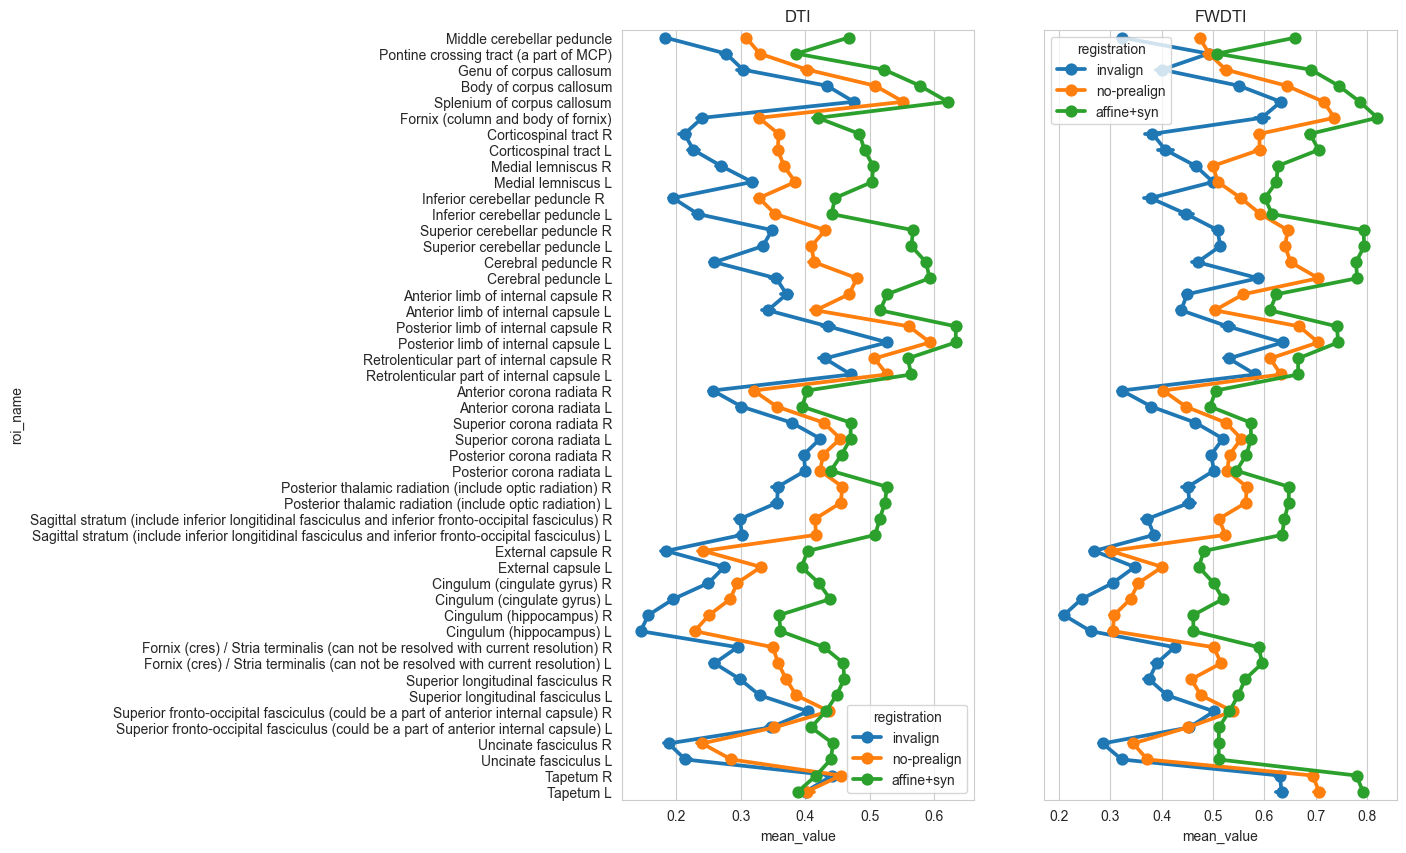

In [6]:
sns.set_style("whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10), sharex=False,sharey=True)

param_list = ["fa","md"]
model_list = ["dti","fwdti"]

idp_df = idp_df[idp_df["roi_name"] != "Unclassified"]
for i, ax in enumerate(axes.flatten()):
    plot_df = idp_df[
        (idp_df["model"] == model_list[i])
        & (idp_df["param"] == "fa")
        ].copy()
    sns.pointplot(y="roi_name", x="mean_value", hue="registration", ax=ax, 
                data=plot_df)
    ax.set_title(f"{model_list[i].upper()}")

## QC

In [7]:
qc_df.head()

,bids_participant_id,session,pipeline,software,registration,dice_label_aff_loop,dice_label_warp_loop,dice_aff_warp_inverse,dice_label_inverse_warp_affine_loop,dice_label_inverse_affine_warp_loop,Jacobian_mean,Jacobian_std,Jacobian_total,participant_id
0,sub-YLOPD03,ses-01,dmri-freewater-2.0.0,dipy,no-prealign,0.98672,0.975006,0.639738,0.641105,0.636677,-0.143335,111.640361,-1.035025e+06,NaN
0,sub-YLOPD03,ses-01,dmri-freewater-2.0.0,dipy,invalign,0.98672,0.980645,0.523985,0.525628,0.513009,-0.143335,111.640361,-1.035025e+06,NaN
0,sub-YLOPD03,ses-01,dmri-freewater-2.0.0,dipy,affine+syn,0.98672,0.968614,0.723793,0.724930,0.728954,-0.143335,111.640361,-1.035025e+06,sub-YLOPD03
0,sub-YLOPD04,ses-01,dmri-freewater-2.0.0,dipy,no-prealign,0.97004,0.972304,0.562594,0.563889,0.572041,-0.252463,153.433803,-1.823044e+06,NaN
0,sub-YLOPD04,ses-01,dmri-freewater-2.0.0,dipy,invalign,0.97004,0.987872,0.314302,0.316946,0.319595,-0.252463,153.433803,-1.823044e+06,NaN


# plot QC metric distributions

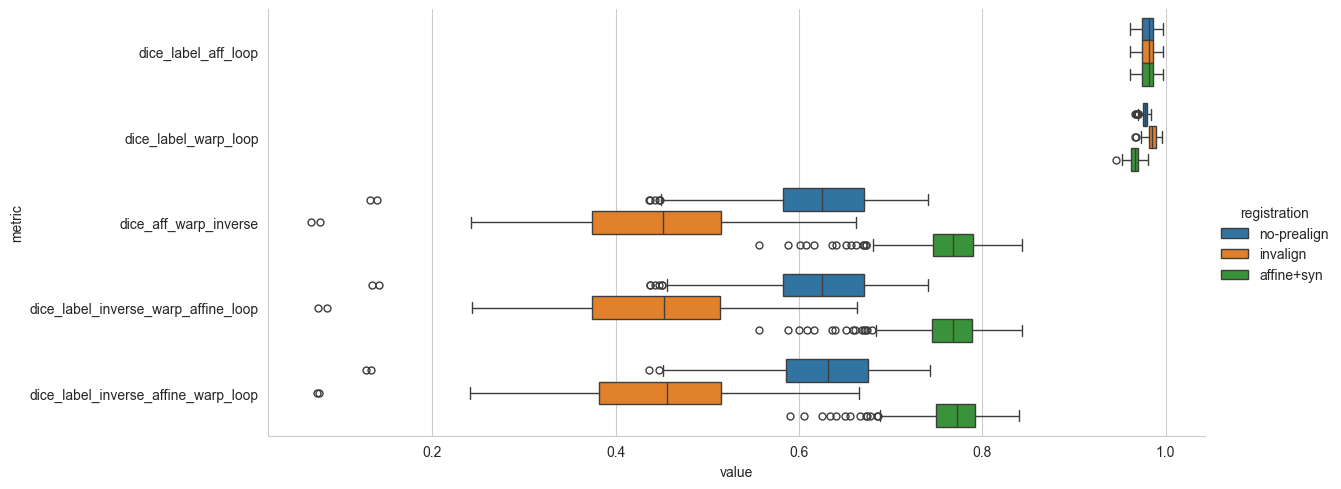

In [8]:
sns.set_style("whitegrid")

dice_param_list = ["dice_label_aff_loop","dice_label_warp_loop","dice_aff_warp_inverse",
              "dice_label_inverse_warp_affine_loop","dice_label_inverse_affine_warp_loop"]

# melt
plot_df = qc_df.melt(id_vars=["participant_id","registration"], value_vars=dice_param_list,
                      var_name="metric", value_name="value")

sns.catplot(y="metric", x="value", kind="box", hue="registration", data=plot_df, aspect=2.5)


## Plot jacobian values

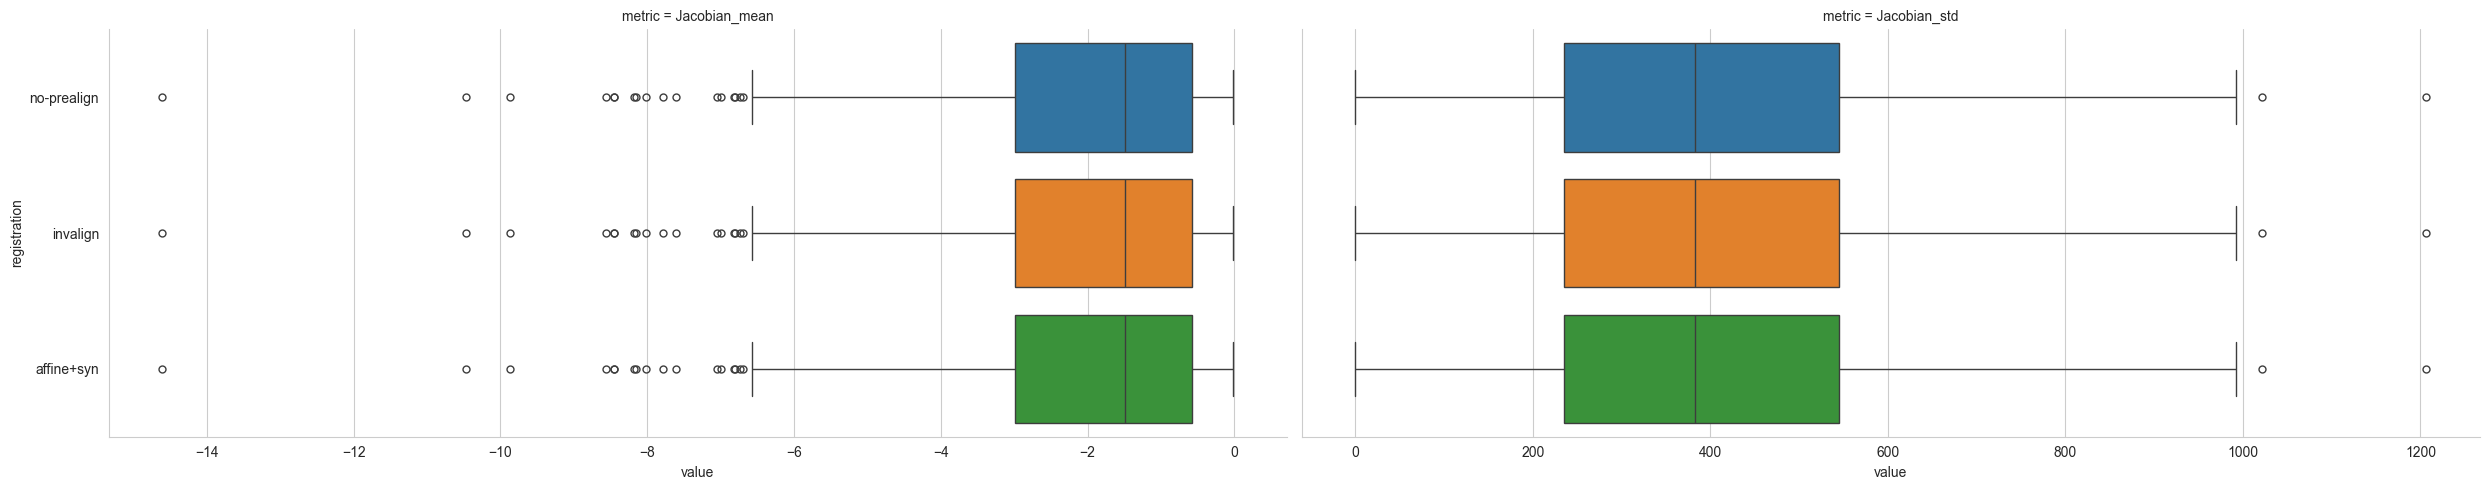

In [10]:
sns.set_style("whitegrid")

jacobian_param_list = ["Jacobian_mean","Jacobian_std"]

# melt
plot_df = qc_df.melt(id_vars=["participant_id","registration"], value_vars=jacobian_param_list,
                      var_name="metric", value_name="value")

sns.catplot(y="registration", x="value", kind="box", hue="registration", col="metric", col_wrap=2,
            data=plot_df, aspect=2.5, sharex=False)


## Correlate QC with jacobians

In [11]:
for dice_param in dice_param_list:
    for jacobian_param in jacobian_param_list:
        for reg in qc_df["registration"].unique():
            sub_qc_df = qc_df[qc_df["registration"]==reg]
            corr = sub_qc_df[dice_param].corr(sub_qc_df[jacobian_param])
            print(f"Registration: {reg}, Dice: {dice_param}, Jacobian: {jacobian_param}, Correlation: {corr:.4f}")

Registration: no-prealign, Dice: dice_label_aff_loop, Jacobian: Jacobian_mean, Correlation: -0.0514
Registration: invalign, Dice: dice_label_aff_loop, Jacobian: Jacobian_mean, Correlation: -0.0514
Registration: affine+syn, Dice: dice_label_aff_loop, Jacobian: Jacobian_mean, Correlation: -0.0514
Registration: no-prealign, Dice: dice_label_aff_loop, Jacobian: Jacobian_std, Correlation: 0.0341
Registration: invalign, Dice: dice_label_aff_loop, Jacobian: Jacobian_std, Correlation: 0.0341
Registration: affine+syn, Dice: dice_label_aff_loop, Jacobian: Jacobian_std, Correlation: 0.0341
Registration: no-prealign, Dice: dice_label_warp_loop, Jacobian: Jacobian_mean, Correlation: -0.0656
Registration: invalign, Dice: dice_label_warp_loop, Jacobian: Jacobian_mean, Correlation: 0.0332
Registration: affine+syn, Dice: dice_label_warp_loop, Jacobian: Jacobian_mean, Correlation: -0.0954
Registration: no-prealign, Dice: dice_label_warp_loop, Jacobian: Jacobian_std, Correlation: 0.0562
Registration: inv

# correlate QC with IDPs

In [13]:
idp_qc_df = pd.merge(idp_df, qc_df[["participant_id"] + dice_param_list], on="participant_id", how="left")

print("idp_qc_df:", idp_qc_df.shape)

# sample subect 
idp_qc_df[(idp_qc_df["participant_id"] == "sub-YLOPD31") & (idp_qc_df["roi_idx"]== 1)]


idp_qc_df: (233856, 16)


,roi_idx,model,param,mean_value,std_value,voxel_count,participant_id,pipeline,software,registration,roi_name,dice_label_aff_loop,dice_label_warp_loop,dice_aff_warp_inverse,dice_label_inverse_warp_affine_loop,dice_label_inverse_affine_warp_loop
85248,1,dti,fa,0.235959,0.201465,24267,sub-YLOPD31,dmri-freewater-2.0.0,dipy,invalign,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85296,1,fwdti,fa,0.311017,0.346316,24267,sub-YLOPD31,dmri-freewater-2.0.0,dipy,invalign,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85344,1,dti,md,0.000569,0.000486,24267,sub-YLOPD31,dmri-freewater-2.0.0,dipy,invalign,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85392,1,fwdti,md,0.054841,0.846321,24267,sub-YLOPD31,dmri-freewater-2.0.0,dipy,invalign,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85440,1,dti,fa,0.353765,0.232123,18233,sub-YLOPD31,dmri-freewater-2.0.0,dipy,no-prealign,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85488,1,fwdti,fa,0.410888,0.366435,18233,sub-YLOPD31,dmri-freewater-2.0.0,dipy,no-prealign,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85536,1,dti,md,0.000612,0.000459,18233,sub-YLOPD31,dmri-freewater-2.0.0,dipy,no-prealign,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85584,1,fwdti,md,0.081358,0.872371,18233,sub-YLOPD31,dmri-freewater-2.0.0,dipy,no-prealign,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85632,1,dti,fa,0.480365,0.167087,13624,sub-YLOPD31,dmri-freewater-2.0.0,dipy,affine+syn,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589
85680,1,fwdti,fa,0.569110,0.320495,13624,sub-YLOPD31,dmri-freewater-2.0.0,dipy,affine+syn,Middle cerebellar peduncle,0.972236,0.963688,0.803093,0.803125,0.800589


In [16]:
# calculate correlation between dice coeff and mean_value for each model, param, roi

corr_df = pd.DataFrame(columns=["model", "param", "roi_idx", "registration", "dice_metric", "correlation"])
for model in idp_qc_df["model"].unique():
    for param in idp_qc_df["param"].unique():
        for roi_idx in idp_qc_df["roi_idx"].unique():
            for reg in idp_qc_df["registration"].unique():
                subset_df = idp_qc_df[
                    (idp_qc_df["model"] == model) &
                    (idp_qc_df["param"] == param) &
                    (idp_qc_df["roi_idx"] == roi_idx) &
                    (idp_qc_df["registration"] == reg)                    
                ]
                if subset_df.shape[0] < 2:
                    continue
                for dice_metric in dice_param_list:
                    corr = subset_df["mean_value"].corr(subset_df[dice_metric])
                    if pd.notnull(corr):
                        corr_df = pd.concat([corr_df, pd.DataFrame({
                            "model": [model],
                            "param": [param],
                            "roi_idx": [roi_idx],
                            "registration": [reg],
                            "dice_metric": [dice_metric],
                            "correlation": [corr]
                        })], axis=0)

corr_df.head()

/tmp/ipykernel_137787/1543651929.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_df = pd.concat([corr_df, pd.DataFrame({


,model,param,roi_idx,registration,dice_metric,correlation
0,dti,fa,1,invalign,dice_label_aff_loop,0.632096
0,dti,fa,1,invalign,dice_label_warp_loop,0.626522
0,dti,fa,1,invalign,dice_aff_warp_inverse,0.039597
0,dti,fa,1,invalign,dice_label_inverse_warp_affine_loop,0.044220
0,dti,fa,1,invalign,dice_label_inverse_affine_warp_loop,0.036902


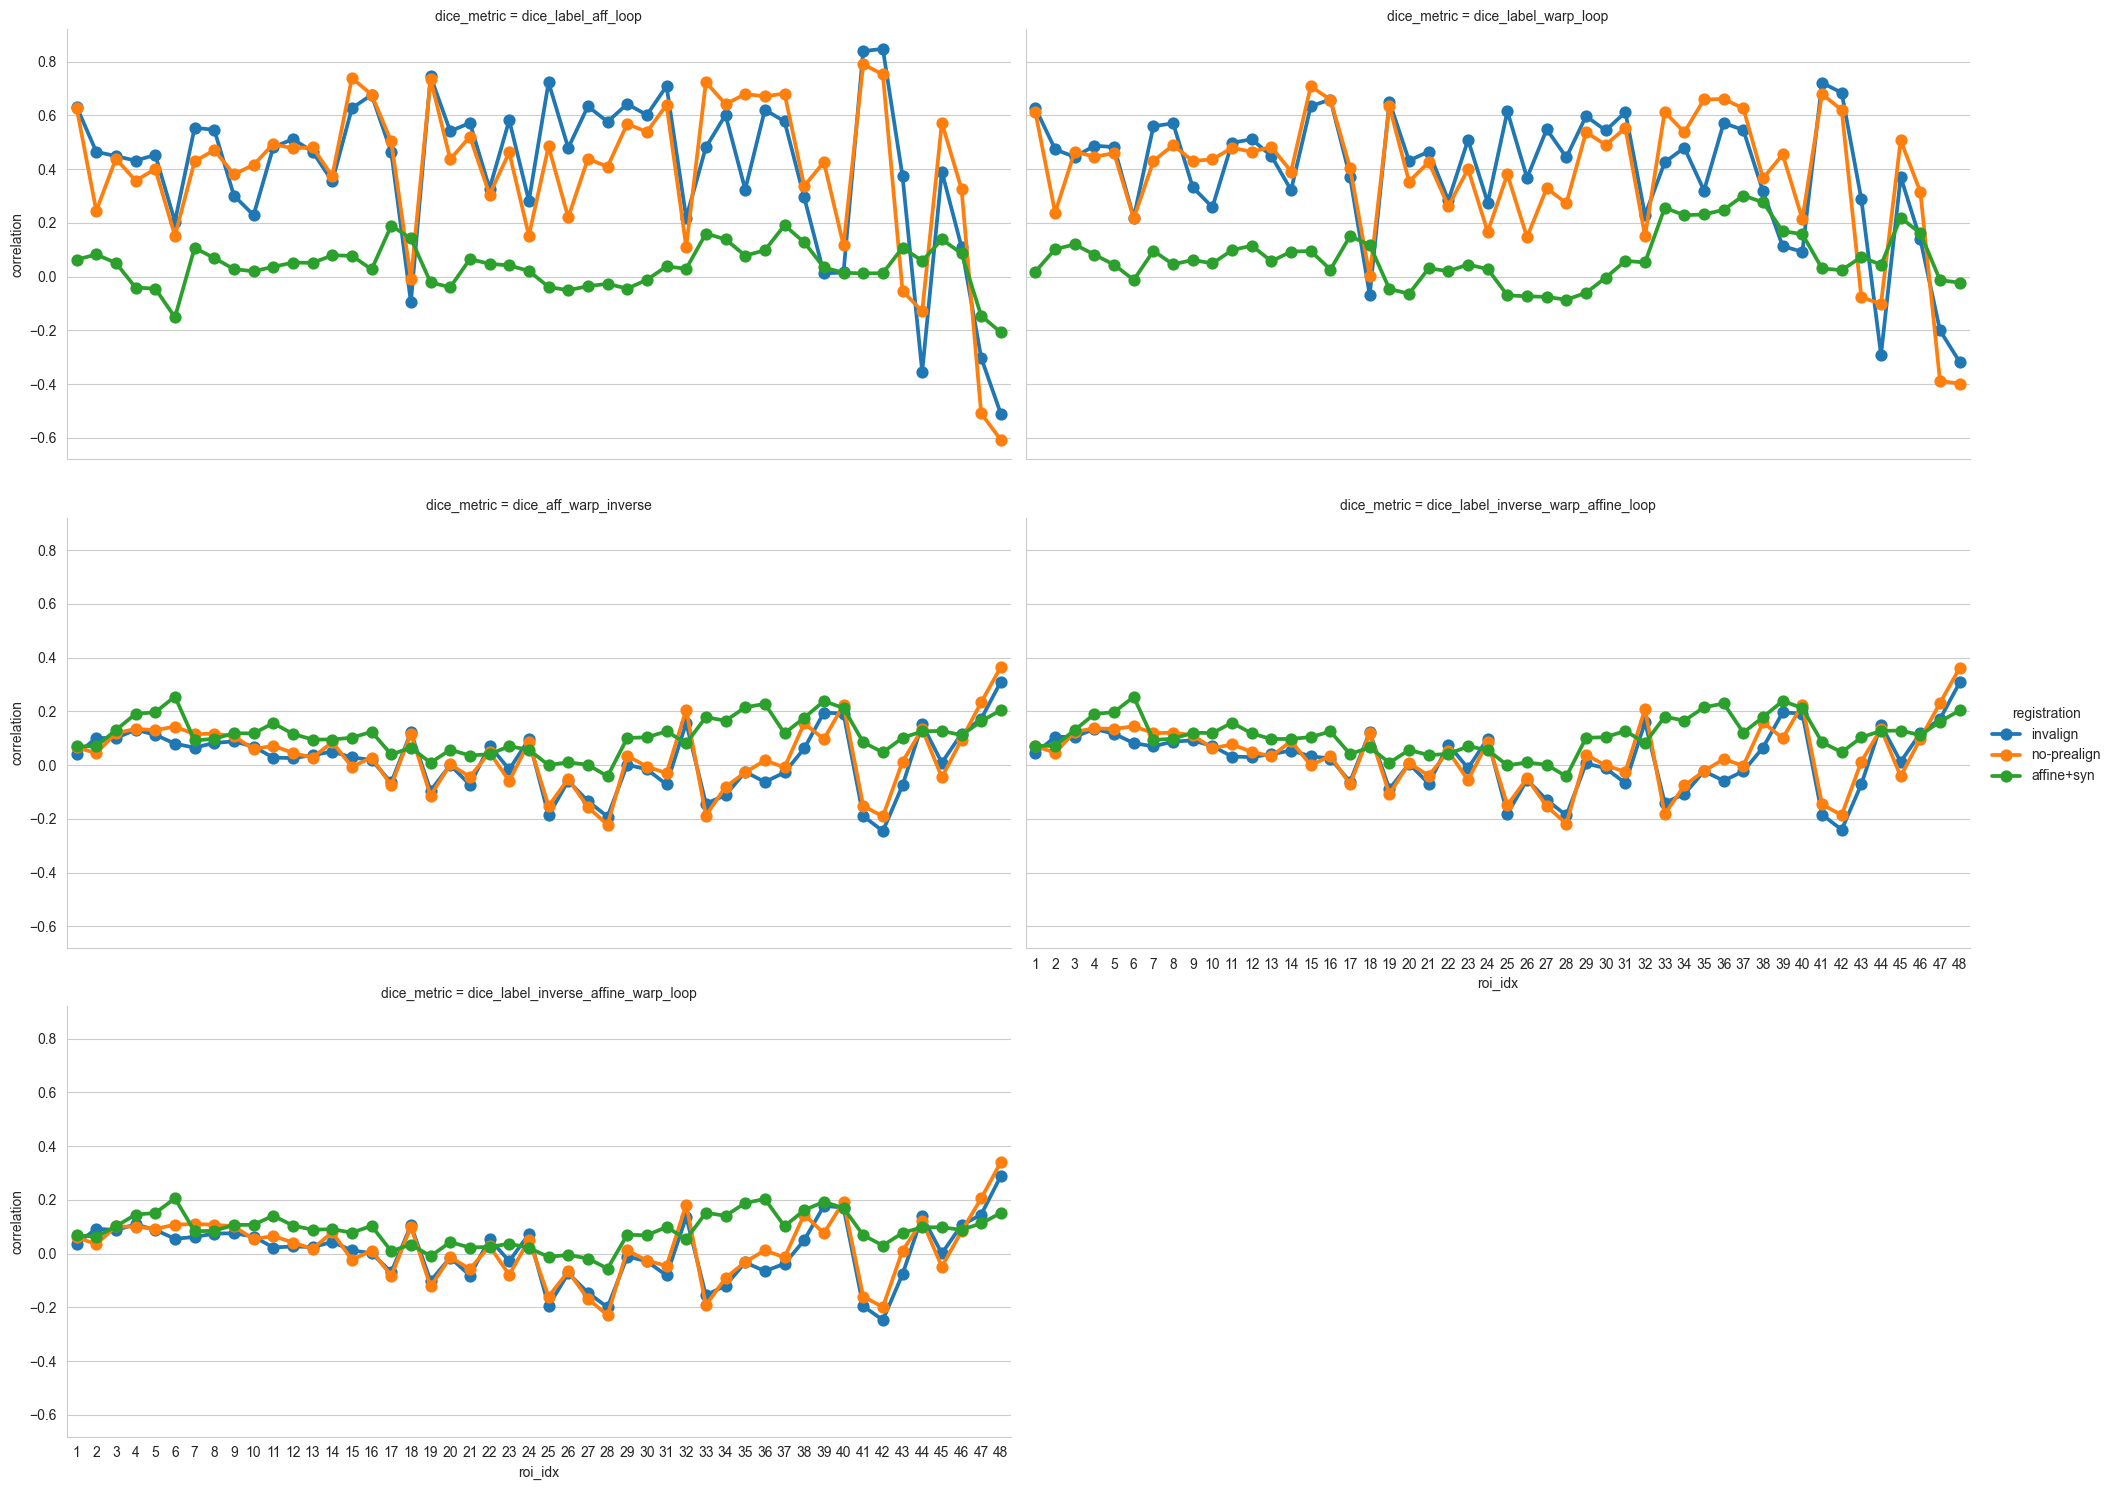

In [17]:
# plot correlation distributions
idp_metric = "fa" # "md"
plot_df = corr_df[(corr_df["model"]=="dti") & (corr_df["param"]==idp_metric)].copy()
sns.set_style("whitegrid")
sns.catplot(x="roi_idx", y="correlation", kind="point", hue="registration", col="dice_metric",col_wrap=2,
            data=plot_df, aspect=2, legend_out=True)

### Jacobian test

In [ ]:
# import disptools.displacements as displacements    
# import disptools.drawing as drawing
# import SimpleITK as sitk
# from dipy.align import affine_registration, syn_registration, write_mapping, read_mapping


/home/nikhil/projects/my_venvs/nipoppy_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# n = 10
# img = drawing.sin_vector_field(n)

# jacobian_pw = displacements.jacobian(img)
# jacobian_itk = sitk.DisplacementFieldJacobianDeterminant(img)

# # On the border, ITK is behaving weird
# jacobian = sitk.GetArrayViewFromImage(jacobian_pw)[1:n-1, 1:n-1, 1:n-1]
# oracle = sitk.GetArrayViewFromImage(jacobian_itk)[1:n-1, 1:n-1, 1:n-1]

# vol_change = displacements.jacobian_to_volume_change(jacobian_pw)
